# Notebook MVP da Sprint 4 (Engenharia de Software) - Flávio Portugal

Esse notebook tem como objetivo classificar se uma água é segura para consumo humano, onde 1 significa Potável e 0 significa Não potável.

##Dataset utilizado foi o Water Potability Dataset:
https://www.kaggle.com/datasets/devanshibavaria/water-potability-dataset-with-10-parameteres


##Colunas do Dataset

1. **ph**:
O pH é um parâmetro importante na avaliação do equilíbrio ácido-base da água. -

1. **Hardness**:
A dureza é a capacidade da água de precipitar sabão causada pelo Cálcio e pelo Magnésio.

1. **Solids**:
O Total dissolved solids (TDS) indica se a água é altamente mineralizada. A água tem a capacidade de dissolver uma ampla gama de minerais ou sais inorgânicos e alguns orgânicos.

1. **Chloramines**:
O cloro e a cloramina são os principais desinfetantes utilizados nos sistemas públicos de água.

1. **Sulfate**:
Sulfatos são substâncias naturais encontradas em minerais, solo e rochas.

1. **Conductivity**:
A água pura não é um bom condutor de corrente elétrica, mas sim um bom isolante. O aumento da condutividade elétrica da água, indica a quantidade de sólidos dissolvidos na água.

1. **Organic_carbon**:
O carbono orgânico total (TOC) é uma medida da quantidade total de carbono em compostos orgânicos em água pura.

1. **Trihalomethanes**:
THMs são produtos químicos que podem ser encontrados na água tratada com cloro.

1. **Turbidity**:
A turbidez é uma medida das propriedades de emissão de luz da água, usada para indicar a qualidade da descarga de resíduos em relação à matéria coloidal.

1. **Potability**:
Indica se a água é segura para consumo humano onde 1 significa Potável e 0 significa Não potável.

A coluna **Potability** é o rótulo categórico (*classe*)

## Imports necessários

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from pickle import dump

ImportError: ignored

## Carga do Dataset

In [ ]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/flavioportugal20/mvp-sprint4-puc/main/data/dataset_water_potability.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Tratamento dos dados do dataset



In [ ]:
# Detecta valores ausentes
dataset.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
# Substitui NaNs pela média das colunas especificadas

dataset['ph'].fillna(value=dataset['ph'].median(),inplace=True)
dataset['Sulfate'].fillna(value=dataset['Sulfate'].median(),inplace=True)
dataset['Trihalomethanes'].fillna(value=dataset['Trihalomethanes'].median(),inplace=True)
#dataset = dataset.dropna()
dataset.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [ ]:
#Renomei as colunas
dataset.columns = ['ph',
                    'hardness',
                    'solids',
                    'chloramines',
                    'sulfate',
                    'conductivity',
                    'organic_carbon',
                    'trihalomethanes',
                    'turbidity',
                    'potability']


# Mostra as primeiras linhas do dataset depois do tratamento
dataset.head()

,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,7.036752,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.073546,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.073546,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
# Verifica se existem apenas zeros e uns na coluna Potability
dataset['potability'].value_counts()

0    1998
1    1278
Name: potability, dtype: int64

## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:9]
y = array[:,9]

# separação do conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.557252 (0.019759)
CART: 0.584733 (0.027086)
NB: 0.618321 (0.020695)
SVM: 0.609924 (0.001527)
GradientBoosting: 0.639313 (0.018562)
AdaBoost: 0.603053 (0.021319)
Bagging: 0.637023 (0.020012)
DecisionTree: 0.580534 (0.028990)
ExtraTree: 0.576718 (0.023863)
RandomForest: 0.658779 (0.019099)
LogisticRegression: 0.609924 (0.001527)
MLP: 0.501527 (0.111018)


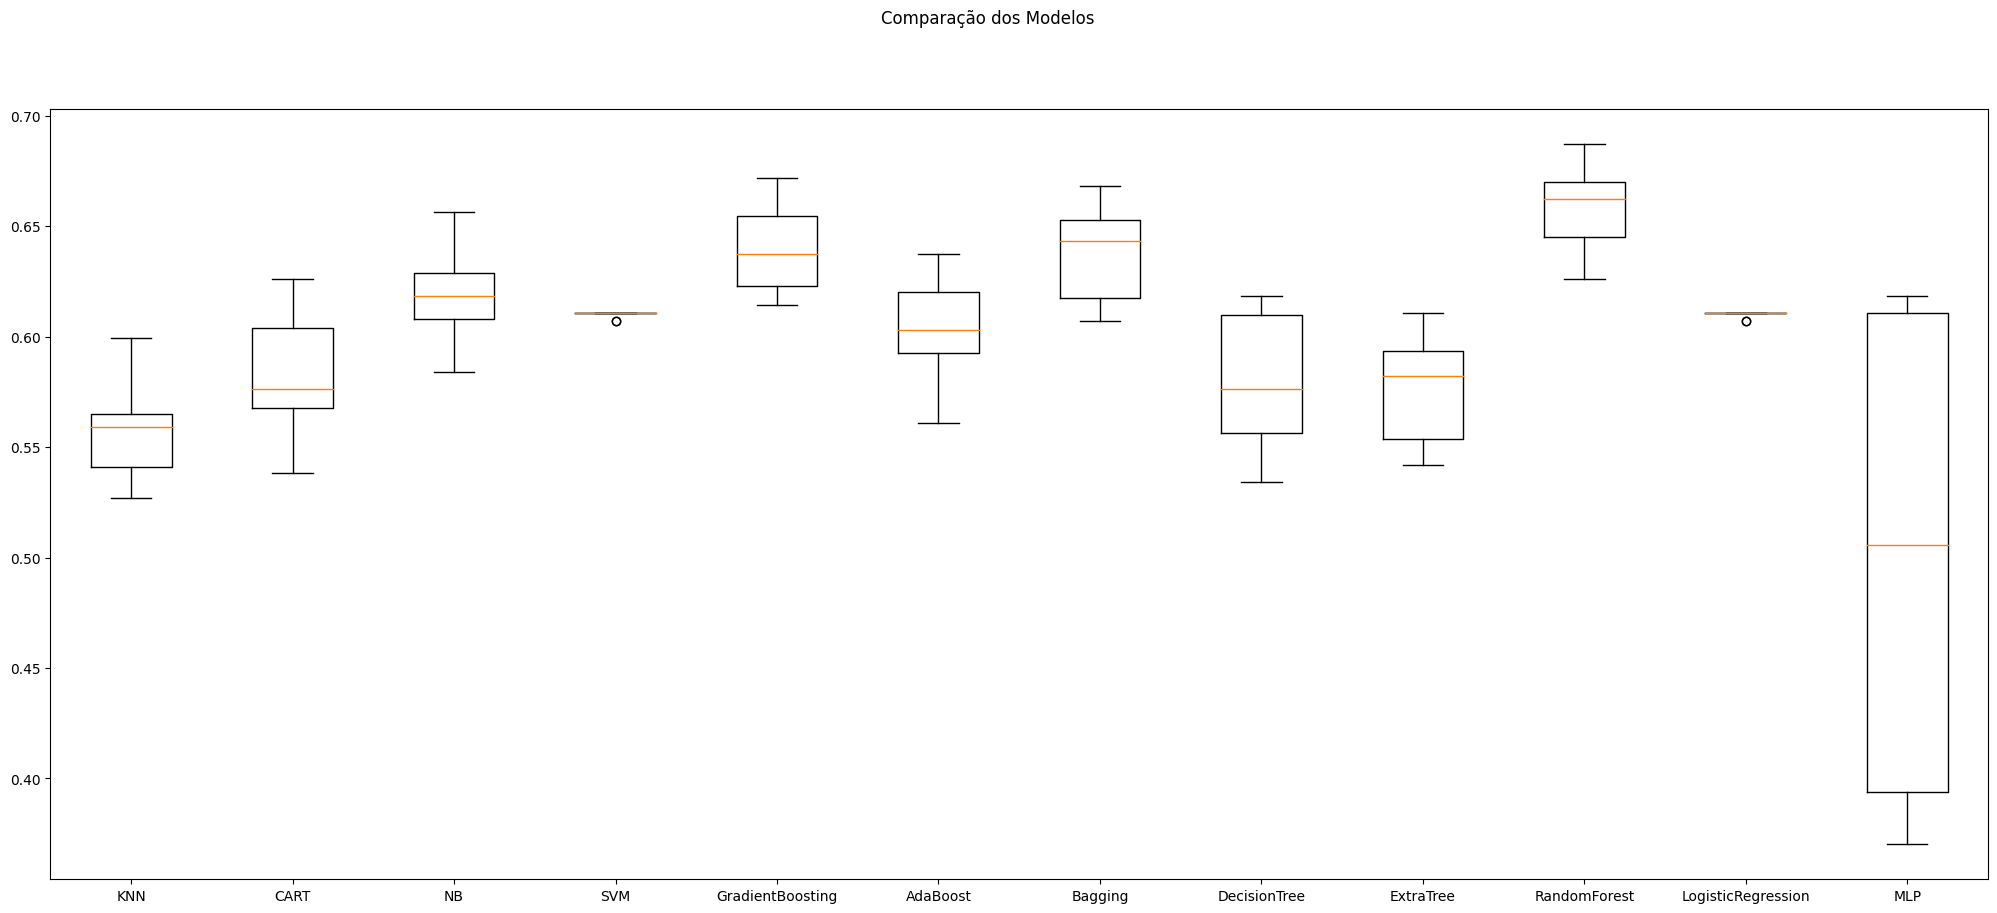

In [ ]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('GradientBoosting', GradientBoostingClassifier()))
models.append(('AdaBoost', AdaBoostClassifier()))
models.append(('Bagging', BaggingClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('ExtraTree', ExtraTreeClassifier()))
models.append(('RandomForest', RandomForestClassifier()))
models.append(('LogisticRegression', LogisticRegression()))
models.append(('MLP', MLPClassifier()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.557 (0.020)
CART-orig: 0.585 (0.027)
NB-orig: 0.618 (0.021)
SVM-orig: 0.610 (0.002)
GradientBoosting-orig: 0.639 (0.019)
AdaBoost-orig: 0.603 (0.021)
Bagging-orig: 0.637 (0.020)
DecisionTree-orig: 0.581 (0.029)
ExtraTree-orig: 0.577 (0.024)
RandomForest-orig: 0.659 (0.019)
LogisticRegression-orig: 0.610 (0.002)
MLP-orig: 0.502 (0.111)
KNN-padr: 0.624 (0.023)
CART-padr: 0.587 (0.030)
NB-padr: 0.617 (0.019)
SVM-padr: 0.667 (0.018)
GradientBoosting-padr: 0.641 (0.017)
AdaBoost-padr: 0.603 (0.021)
Bagging-padr: 0.639 (0.019)
DecisionTree-padr: 0.588 (0.038)
ExtraTree-padr: 0.564 (0.025)
RandomForest-padr: 0.656 (0.017)
LogisticRegression-padr: 0.611 (0.003)
MLP-padr: 0.670 (0.020)
KNN-norm: 0.611 (0.020)
CART-norm: 0.586 (0.029)
NB-norm: 0.617 (0.019)
SVM-norm: 0.659 (0.013)
GradientBoosting-norm: 0.641 (0.018)
AdaBoost-norm: 0.603 (0.021)
Bagging-norm: 0.644 (0.026)
DecisionTree-norm: 0.589 (0.027)
ExtraTree-norm: 0.555 (0.025)
RandomForest-norm: 0.666 (0.023)
LogisticRegressi

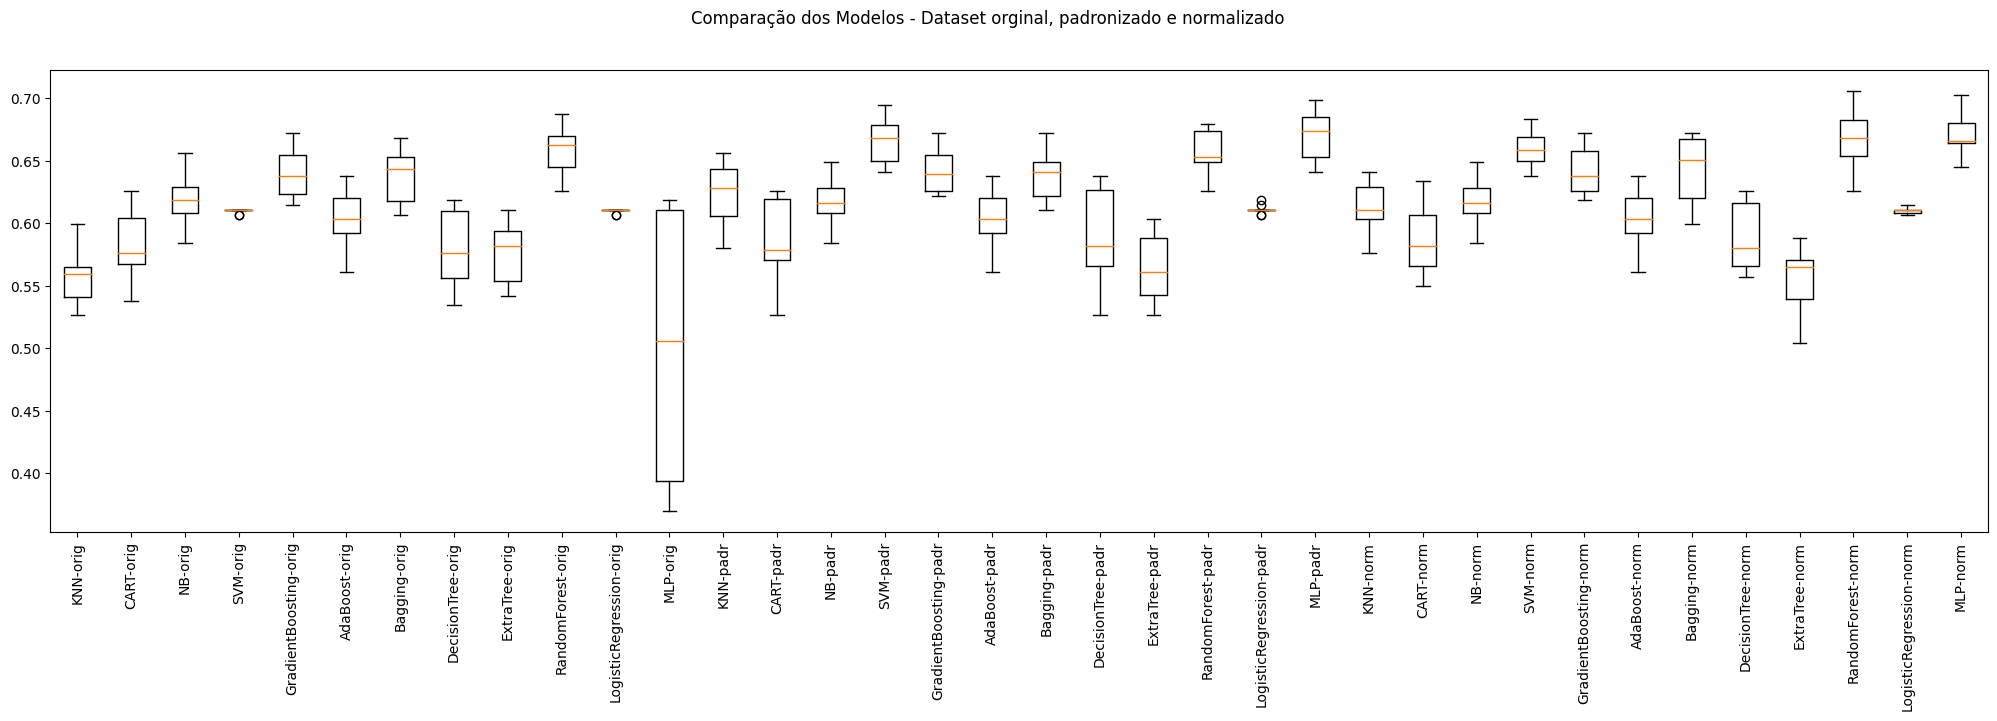

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
gb = ('GradientBoosting', GradientBoostingClassifier())
ab = ('AdaBoost', AdaBoostClassifier())
bagging = ('Bagging', BaggingClassifier())
dt = ('DecisionTree', DecisionTreeClassifier())
et = ('ExtraTree', ExtraTreeClassifier())
rf = ('RandomForest', RandomForestClassifier())
pl = ('LogisticRegression', LogisticRegression())
mlp = ('MLP', MLPClassifier())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('GradientBoosting-orig', Pipeline([gb])))
pipelines.append(('AdaBoost-orig', Pipeline([ab])))
pipelines.append(('Bagging-orig', Pipeline([bagging])))
pipelines.append(('DecisionTree-orig', Pipeline([dt])))
pipelines.append(('ExtraTree-orig', Pipeline([et])))
pipelines.append(('RandomForest-orig', Pipeline([rf])))
pipelines.append(('LogisticRegression-orig', Pipeline([pl])))
pipelines.append(('MLP-orig', Pipeline([mlp])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('GradientBoosting-padr', Pipeline([standard_scaler, gb])))
pipelines.append(('AdaBoost-padr', Pipeline([standard_scaler, ab])))
pipelines.append(('Bagging-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('DecisionTree-padr', Pipeline([standard_scaler, dt])))
pipelines.append(('ExtraTree-padr', Pipeline([standard_scaler, et])))
pipelines.append(('RandomForest-padr', Pipeline([standard_scaler, rf])))
pipelines.append(('LogisticRegression-padr', Pipeline([standard_scaler, pl])))
pipelines.append(('MLP-padr', Pipeline([standard_scaler, mlp])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('GradientBoosting-norm', Pipeline([min_max_scaler, gb])))
pipelines.append(('AdaBoost-norm', Pipeline([min_max_scaler, ab])))
pipelines.append(('Bagging-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('DecisionTree-norm', Pipeline([min_max_scaler, dt])))
pipelines.append(('ExtraTree-norm', Pipeline([min_max_scaler, et])))
pipelines.append(('RandomForest-norm', Pipeline([min_max_scaler, rf])))
pipelines.append(('LogisticRegression-norm', Pipeline([min_max_scaler, pl])))
pipelines.append(('MLP-norm', Pipeline([min_max_scaler, mlp])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do RandomForest (cerca de 12 minutos)
np.random.seed(7) # definindo uma semente global para este bloco
pipelines = []

# Definindo os componentes do pipeline
rf = ('RandomForest', RandomForestClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('rf-orig', Pipeline(steps=[rf])))
pipelines.append(('rf-padr', Pipeline(steps=[standard_scaler, rf])))
pipelines.append(('rf-norm', Pipeline(steps=[min_max_scaler, rf])))

param_grid = {
    'RandomForest__n_estimators': [60,70,80,100,200,300,400,500,600,700]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: rf-orig - Melhor: 0.672137 usando {'RandomForest__n_estimators': 300}


KeyboardInterrupt: ignored

## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(n_estimators=700)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.6935975609756098


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(n_estimators=700)

## Exportação do modelo resultante

In [ ]:
# Exportação do modelo
filename = 'model2.pkl'
dump(model, open(filename, 'wb'))